(<Figure size 400x200 with 1 Axes>, <Axes: >)

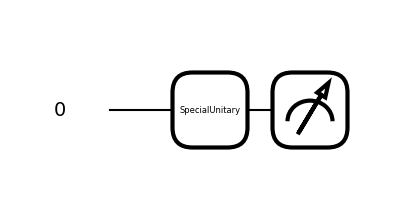

In [101]:
import pennylane as qml
import numpy as np
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jnp = jax.numpy

dev = qml.device('default.qubit', wires = 1)
#Define Hamiltonian
obs = [qml.Z(0),qml.Y(0)]
coeff = [0.6,-0.8]
H = qml.Hamiltonian(coeff,obs)

def qfunc(theta):
    qml.SpecialUnitary(theta,wires = 0)
    return qml.expval(H)

circuit = qml.QNode(qfunc,dev,interface='jax',diff_method='parameter-shift')
 # For 1 qubit, only 3 parameters are required. 
theta = jnp.array([0.4,0.2,-0.5])
theta = np.array([0.4,0.2,-0.5])

qml.draw_mpl(circuit,decimals=2)(theta)


In [102]:
# we will apply finite difference approach to compute the gradient wrt second parameter

def fin_diff(weights,idx,delta):   
    new_weights = weights.reshape(-1)
    s = delta
    def gradient(weights,idx):
        weights_1 = weights.copy()
        weights_1[idx] += s/2
        plus_eval = circuit(weights_1)
        weights_1[idx] -= s
        minus_eval = circuit(weights_1)
        return (plus_eval-minus_eval)/(s)
    return gradient(weights,idx)

fin_diff(theta,1,0.75)
qml.ops.qubit.special_unitary.pauli_basis_matrices(3)
qml.SpecialUnitary


pennylane.ops.qubit.special_unitary.SpecialUnitary

In [103]:
#Stochastic Parameter-Shift Rule

num_wires = 6
wires = list(range(num_wires))
np.random.seed(62213)

coefficients = np.random.randn(4**num_wires - 1)
# Create the matrices for the entire Pauli basis
basis = qml.ops.qubit.special_unitary.pauli_basis_matrices(num_wires)
# Construct the Hamiltonian from the normal random coefficients and the basis
H_matrix = qml.math.tensordot(coefficients, basis, axes=[[0], [0]])
H = qml.Hermitian(H_matrix, wires=wires)
# # Compute the ground state energy
E_min = min(qml.eigvals(H))
print(f"Ground state energy: {E_min:.5f}")


Ground state energy: -119.70320


In [104]:
loc = 2
d = loc**4 - 1  # d = 15 for two-qubit operations
dev = qml.device("default.qubit", wires=num_wires)
# two blocks with two layers. Each layer contains three operations with d parameters
param_shape = (2, 2, 2, d)
init_params = np.zeros(param_shape)


# def circuit(params, operation=None):
#     """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
#     Parameters are assumed to have the dimensions (number of blocks, number of
#     wires per operation, number of operations per layer, and number of parameters
#     per operation), in that order.
#     """
#     for params_block in params:
#         for i, params_layer in enumerate(params_block):
#             for j, params_op in enumerate(params_layer):
#                 wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
#                 operation(params_op, wires_op)
#                 print(operation)
#     return qml.expval(H)

# qnode = qml.QNode(circuit, dev, interface="jax")
# print(qml.draw(qnode)(init_params, qml.SpecialUnitary))
#print(init_params)
# for params_block in init_params:
#    # print(params_block)
#     for i, params_layer in enumerate(params_block):
#         #print(params_layer)
#         for j, params_op in enumerate(params_layer):
#             print(params_op)
# #             wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
# #             operation(params_op, wires_op)
# #qnode
print(init_params)


[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]]


In [105]:
def two_qubit_decomp(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    i, j = wires
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[:3], wires=i)
    qml.Rot(*params[3:6], wires=j)
    qml.CNOT(wires=[j, i])  # First CNOT
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])  # Second CNOT
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])  # Third CNOT
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[9:12], wires=i)
    qml.Rot(*params[12:15], wires=j)


# The three building blocks on two qubits we will compare are:
operations = {
    ("Decomposition", "decomposition"): two_qubit_decomp,
    ("PauliRot sequence",) * 2: qml.ArbitraryUnitary,
    ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,
}

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DELL\AppData\Local\Temp\ipykernel_39240\391022573.py:24: SyntaxWarning: invalid escape sequence '\m'
  ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,
